In [20]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if "adrian_sensorium" not in os.getcwd():
    os.chdir("adrian_sensorium")

print('Working directory:', os.getcwd())

Working directory: c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\adrian_sensorium


In [21]:
# %%capture
# !pip install -e ./lib/mei

## Restart Kernel after mei-module installation!

In [22]:
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from nnfabrik.builder import get_data, get_model
from gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores

In [23]:
from sensorium.utility.training import read_config

In [24]:
seed=31415
# data_key_aut = "29027-6-17-1-6-5"
# data_key_wt = "29028-1-17-1-6-5"
# data_key_sens2 = "23964-4-22"
# autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
# sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [25]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

In [26]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE11086/2023_12_16']

In [27]:
# dataset_fn = 'sensorium.datasets.static_loaders'

# filenames_autistic = [autistic_mouse_dataPath, ]

# dataset_config_autistic = {'paths': filenames_autistic,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

# filenames_wildtype = [wildtype_mouse_dataPath, ]

# dataset_config_wildtype = {'paths': filenames_wildtype,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':1,
#                  }

# dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

# filenames_sens2 = [sens2_dataPath, ]

# dataset_config_sens2 = {'paths': filenames_sens2,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': False,
#                  'batch_size': 128,
#                  'scale':0.25,
#                  }

# dataloaders_sens2 = get_data(dataset_fn, dataset_config_sens2)

In [28]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

In [29]:
# model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
# model_config = {'pad_input': False,
#   'stack': -1,
#   'layers': 4,
#   'input_kern': 9,
#   'gamma_input': 6.3831,
#   'gamma_readout': 0.0076,
#   'hidden_kern': 7,
#   'hidden_channels': 64,
#   'depth_separable': True,
#   'grid_mean_predictor': {'type': 'cortex',
#    'input_dimensions': 2,
#    'hidden_layers': 1,
#    'hidden_features': 30,
#    'final_tanh': True},
#   'init_sigma': 0.1,
#   'init_mu_range': 0.3,
#   'gauss_type': 'full',
#   'shifter': False,
# }

# model_a = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_autistic,
#                   seed=seed,
#                   )
# model_wt = get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_wildtype,
#                   seed=seed,
#                   )

# model_sens2= get_model(model_fn=model_fn,
#                   model_config=model_config,
#                   dataloaders=dataloaders_sens2,
#                   seed=seed,
#                   )

In [30]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
# model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
# model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
# model_sens2.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

In [32]:
# model_a.eval()
# model_wt.eval()
# model_sens2.eval()

In [33]:
# correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
# correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
# correlation_to_average_s2 = get_signal_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)

# df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
# df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
# df_cta_s2 = get_df_for_scores(session_dict=correlation_to_average_s2, measure_attribute="Correlation to Average")

In [34]:
# top200units_a = df_cta_a.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_wt = df_cta_wt.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
# top200units_s2 = df_cta_s2.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()

In [35]:
from sensorium.models.ensemble import EnsemblePrediction
ensemble = EnsemblePrediction(model_list, mode='mean')

In [36]:
correlation_to_average = get_signal_correlations(ensemble, dataloaders, tier='test', device='cuda', as_dict=True)

df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

In [37]:
top200units = df_cta.sort_values(['Correlation to Average'], ascending=False).reset_index()[:200]["index"].to_list()

In [38]:
config_mei = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

In [39]:
data_key = 'LPE11086-LPE11086_2023_12_16-0'

In [40]:
meis = []
for i in tqdm(top200units):
    mei_out, _, _ = gradient_ascent(ensemble, config_mei, data_key=data_key, unit=i, seed=seed, shape=(1, 1, 64, 96))
    meis.append(mei_out)
# torch.save(meis, "MEIs/meis.pth")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0


RuntimeError: Given groups=1, weight of size [64, 4, 9, 9], expected input[1, 1, 64, 96] to have 4 channels, but got 1 channels instead

In [ ]:
# meis_a = []
# for i in tqdm(top200units_a):
#     mei_a, _, _ = gradient_ascent(model_a, config_mei, data_key=data_key_aut, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_a.append(mei_a)
# torch.save(meis_a, "MEIs/meis_a200.pt")

In [23]:
# meis_wt = []
# for i in tqdm(top200units_wt):
#     mei_wt, _, _ = gradient_ascent(model_wt, config, data_key=data_key_wt, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_wt.append(mei_wt)
# torch.save(meis_wt, "MEIs/meis_wt200.pt")

In [24]:
# meis_s2 = []

# for i in tqdm(top200units_s2):
#     mei_s2, _, _ = gradient_ascent(model_sens2, config, data_key=data_key_sens2, unit=i, seed=seed, shape=(1,1,36,64))
#     meis_s2.append(mei_s2)
# torch.save(meis_s2, "MEIs/meis_s200.pt")

In [13]:
# meis_a = torch.load("MEIs/meis_a200.pt")
# meis_wt = torch.load("MEIs/meis_wt200.pt")

In [46]:
meis = torch.load("MEIs/meis.pth")

  0%|          | 0/20 [00:00<?, ?it/s]

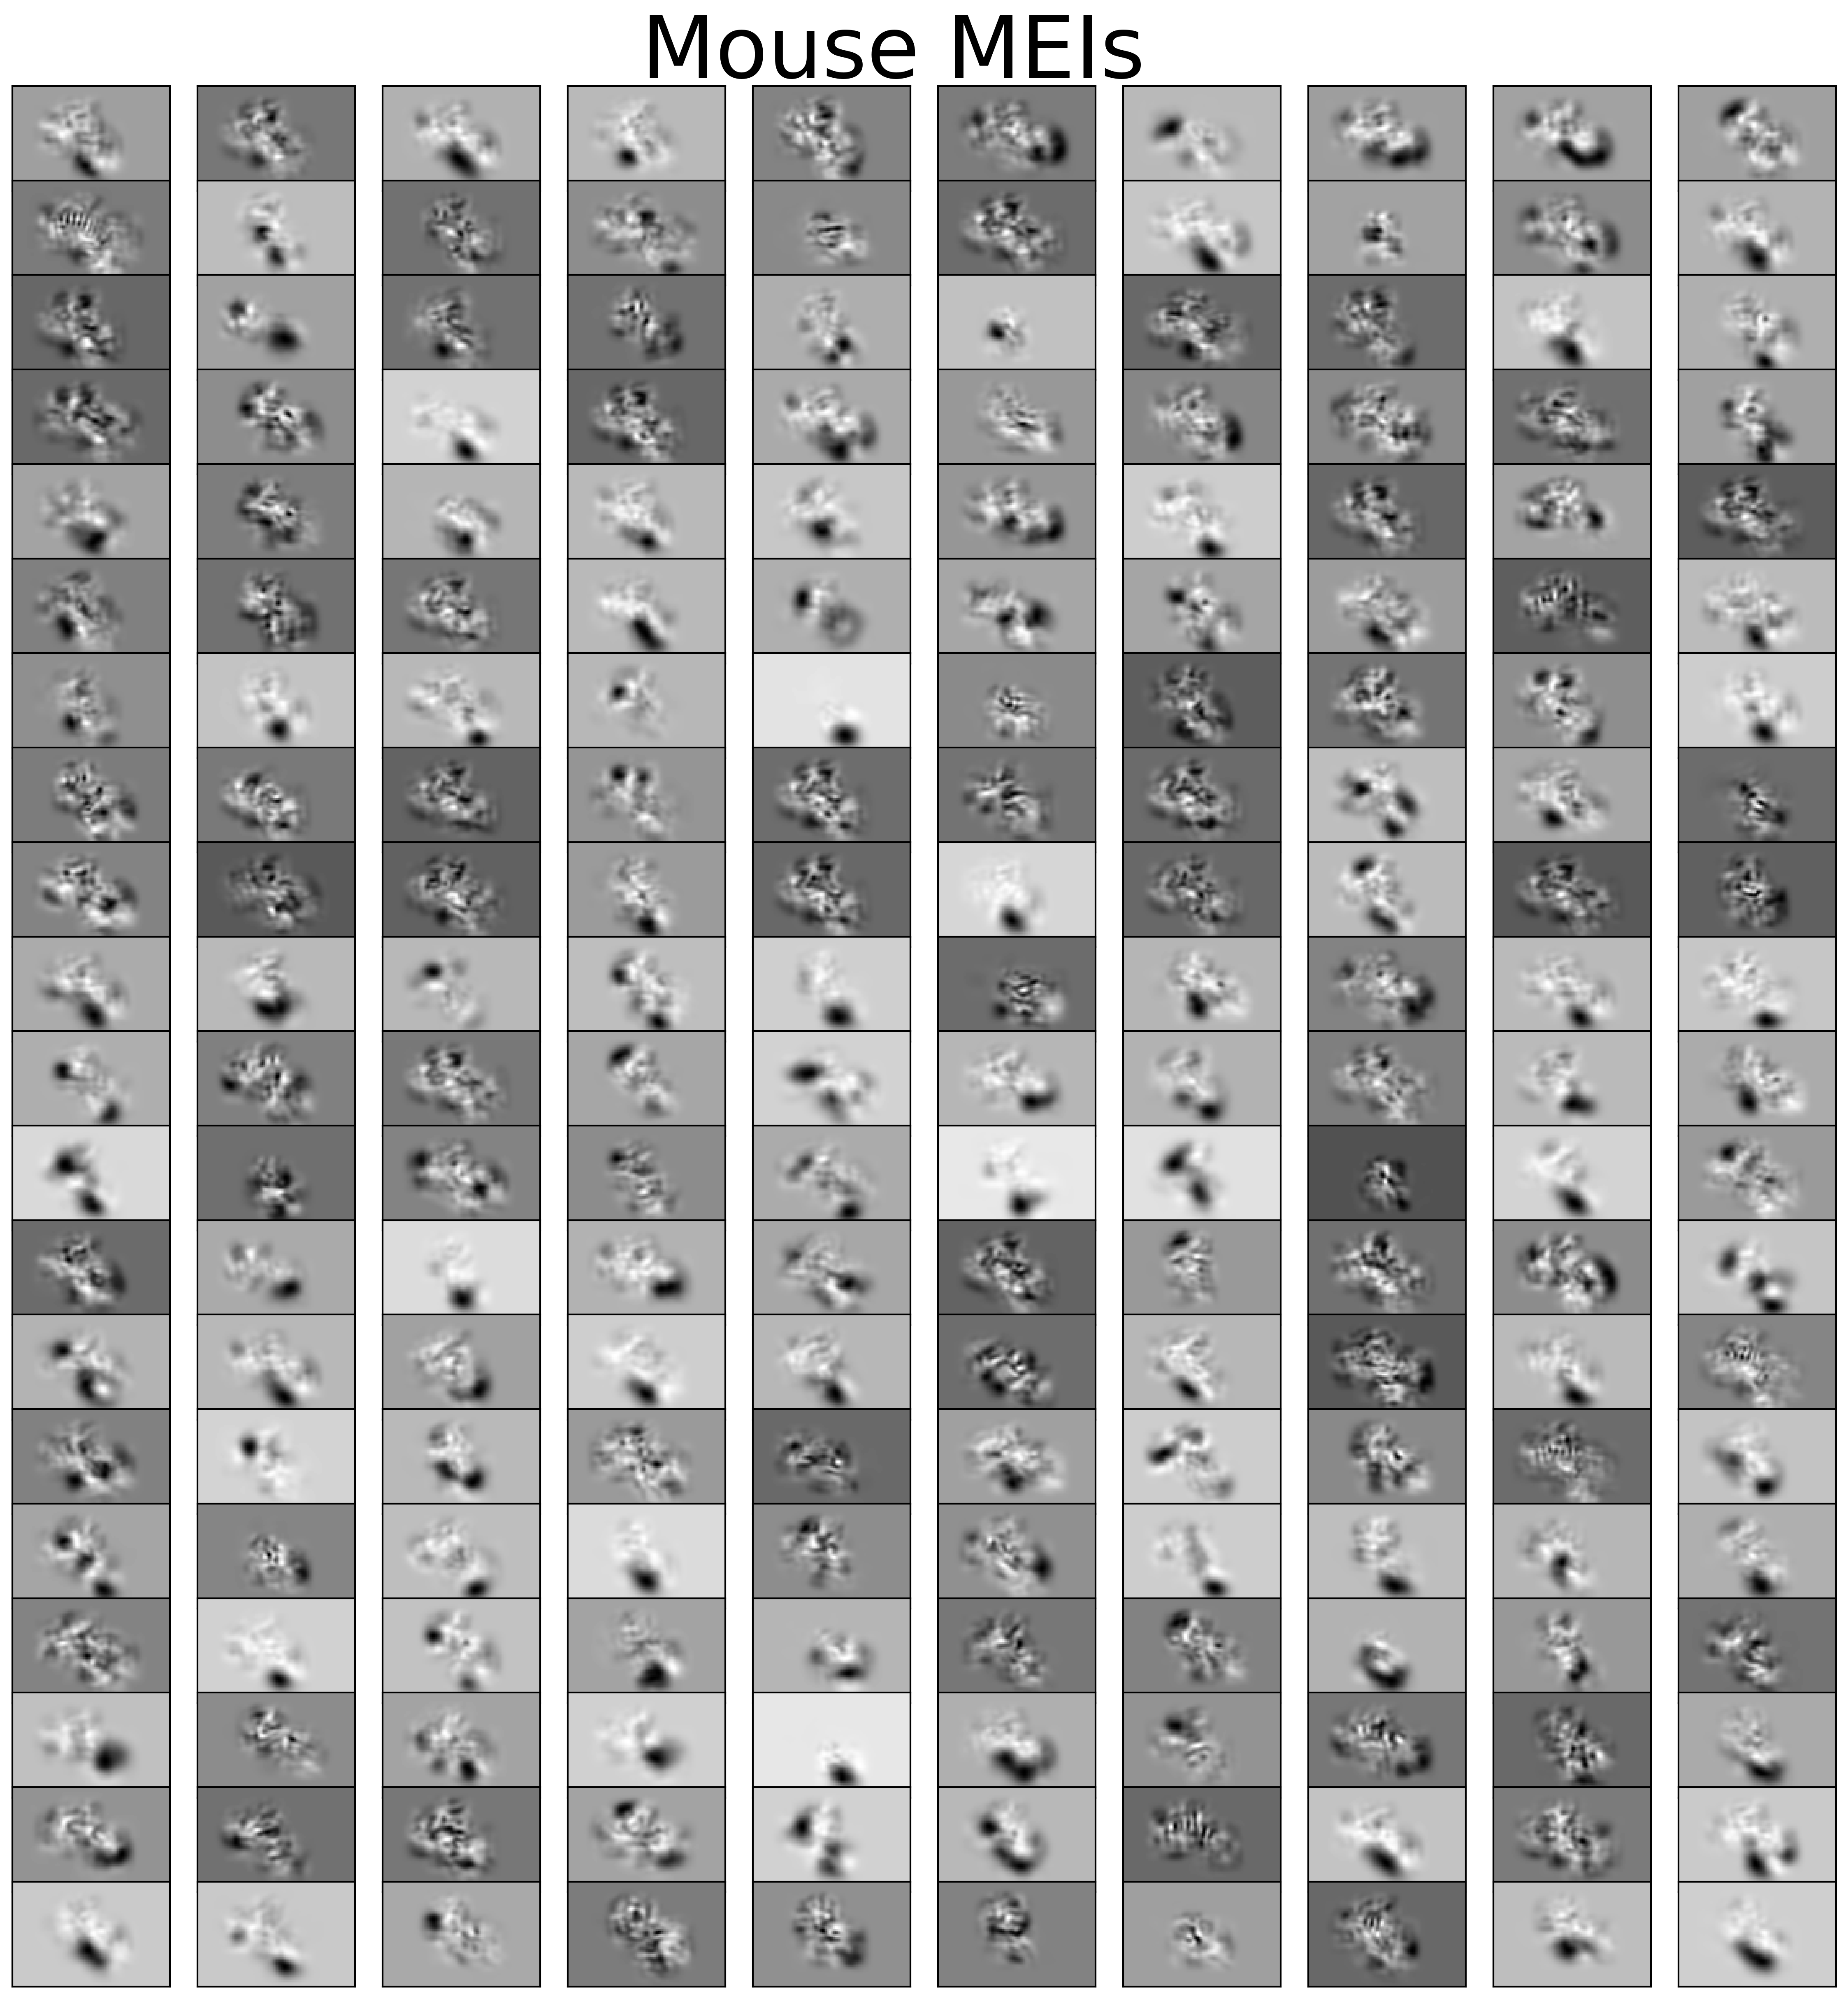

In [51]:
fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
fig.suptitle("Mouse MEIs", y=0.91, fontsize=50)
for i in tqdm(range(20)):
    for j in range(10):
        index = i * 10 + j
        axes[i, j].imshow(meis[index].reshape(4, 64, 96).mean(0), cmap="gray")#, vmin=-1, vmax=1)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
os.makedirs("Plots", exist_ok=True)
plt.savefig("Plots/MouseMEIsTop200.png", dpi=300)
plt.show()

100%|██████████| 20/20 [00:00<00:00, 229.75it/s]


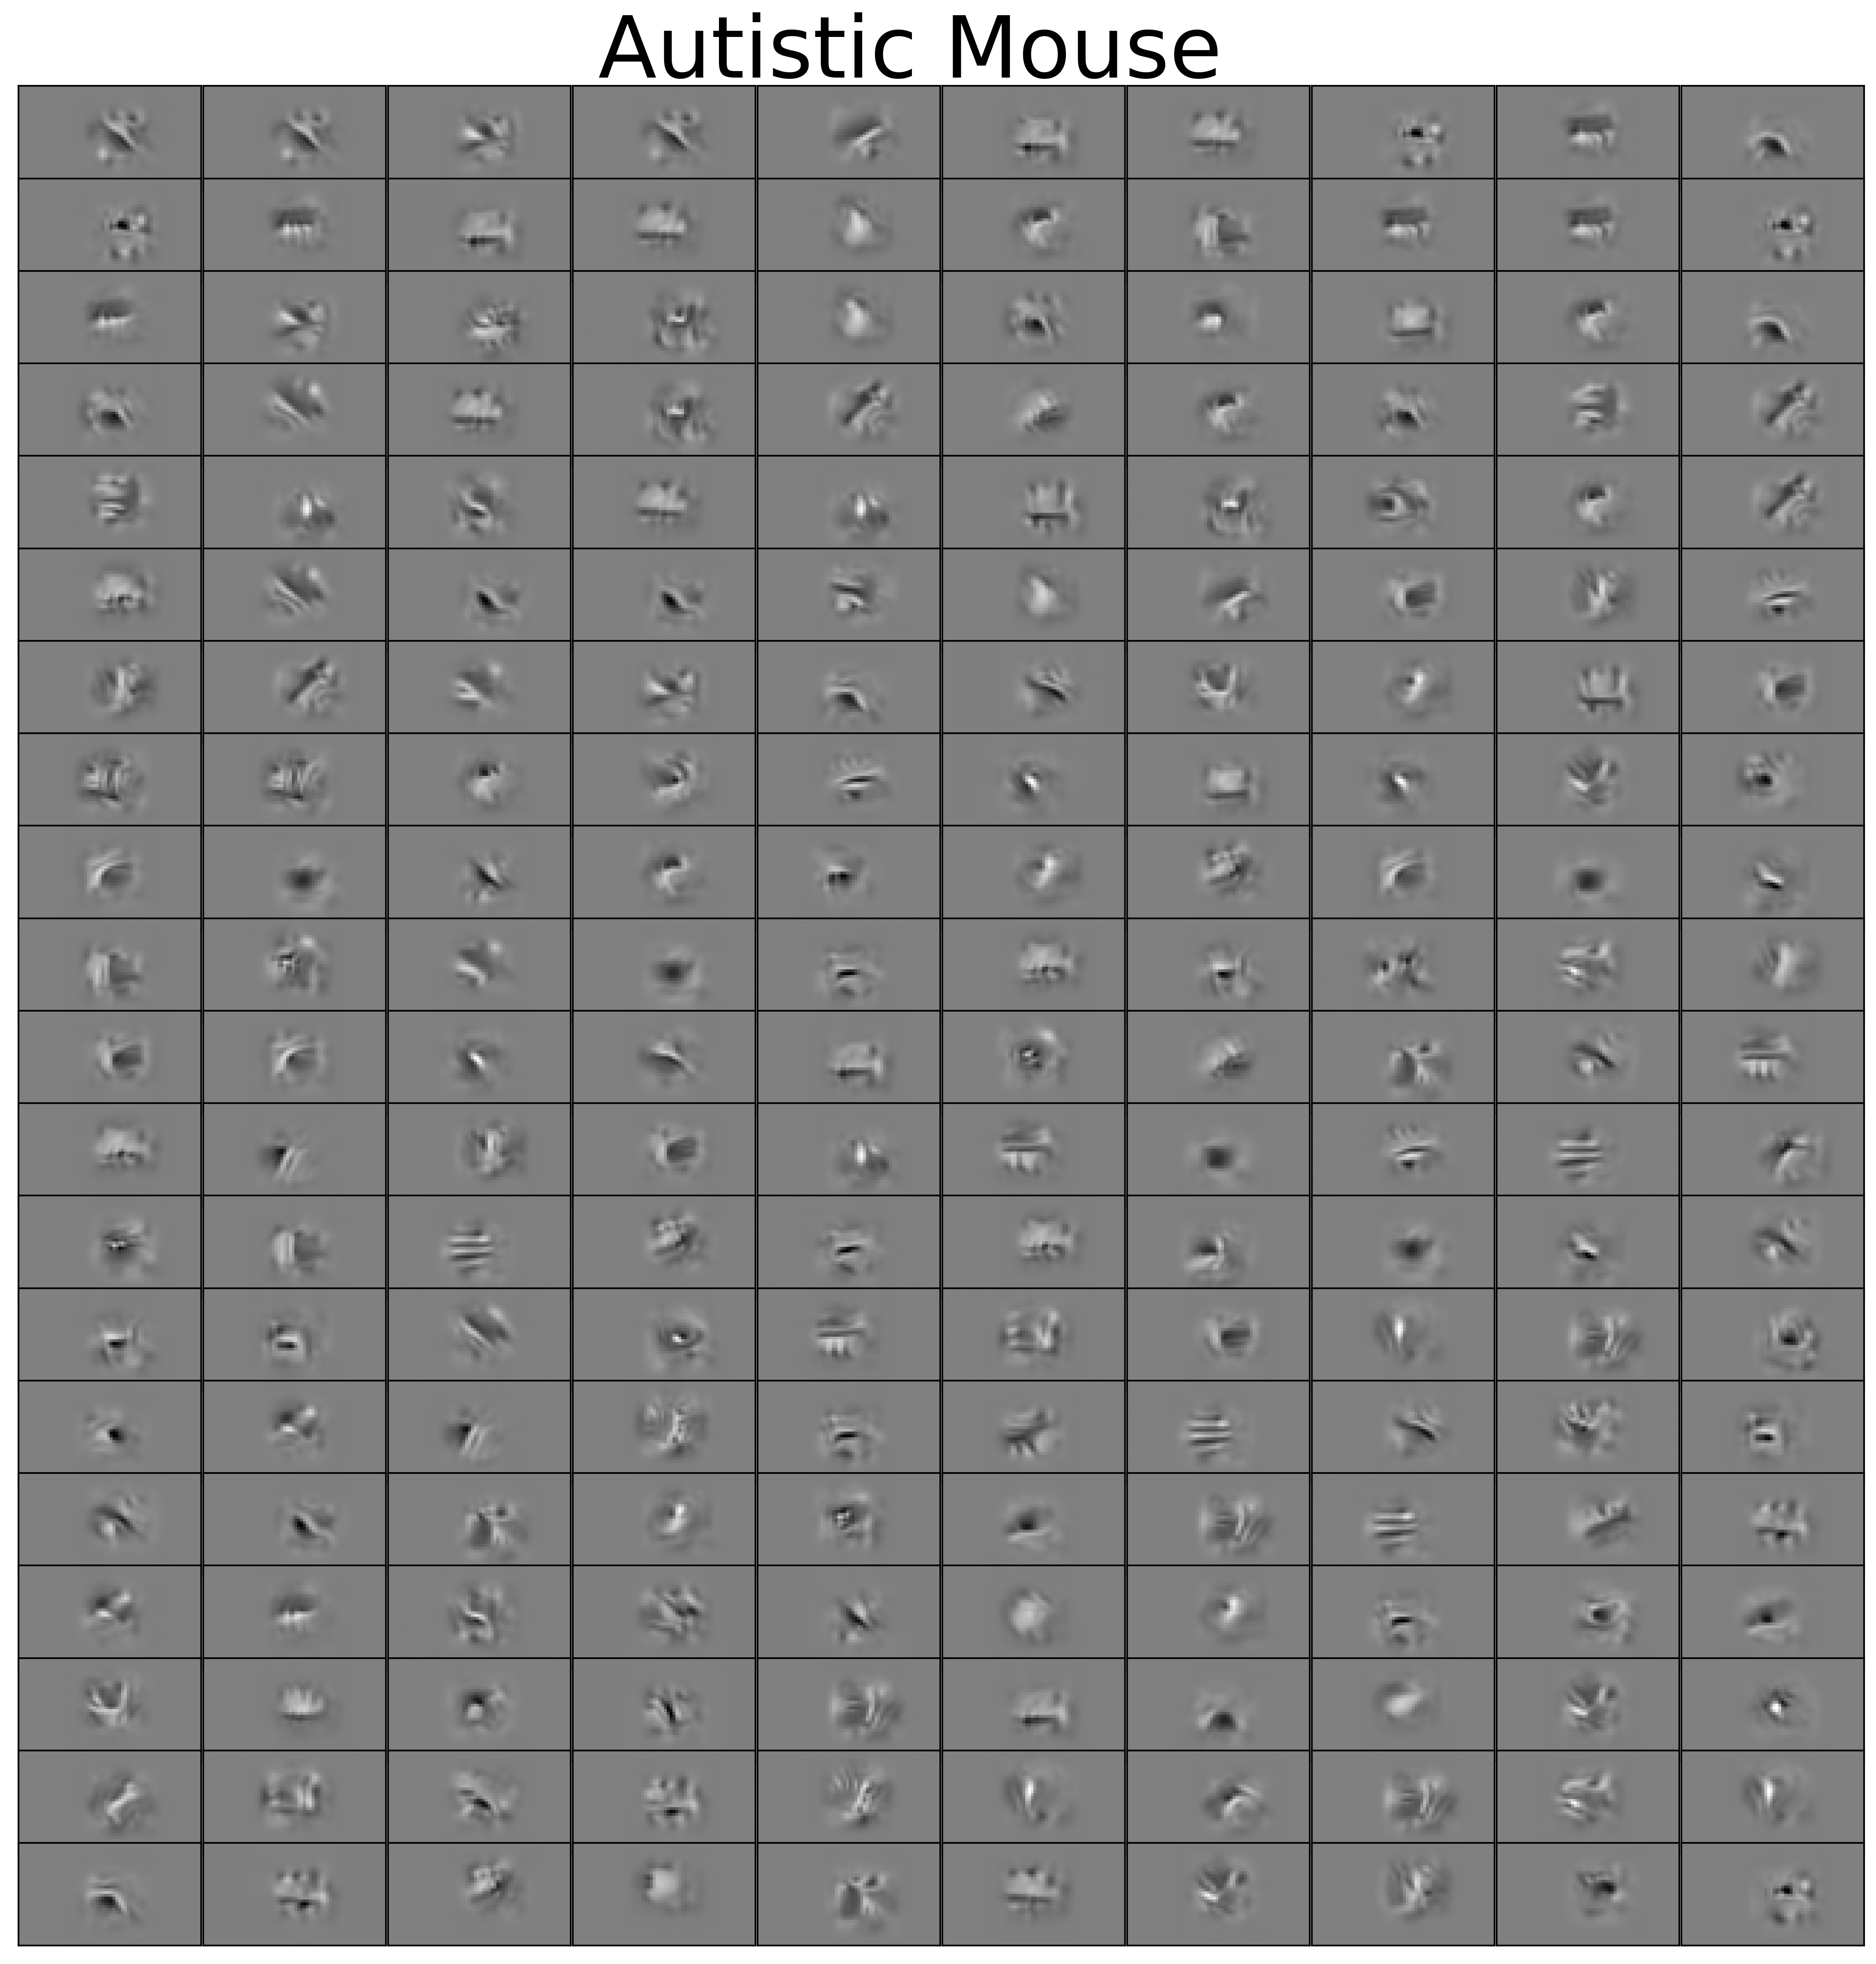

In [14]:
# fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
# fig.suptitle("Autistic Mouse", y=0.91, fontsize=50)
# for i in tqdm(range(20)):
#     for j in range(10):
#         index = i * 10 + j
#         axes[i, j].imshow(meis_a[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
#         axes[i, j].spines['top'].set_color('black')
#         axes[i, j].spines['bottom'].set_color('black')
#         axes[i, j].spines['left'].set_color('black')
#         axes[i, j].spines['right'].set_color('black')
#         axes[i, j].spines['top'].set_linewidth(1)
#         axes[i, j].spines['bottom'].set_linewidth(1)
#         axes[i, j].spines['left'].set_linewidth(1)
#         axes[i, j].spines['right'].set_linewidth(1)
#         axes[i, j].set_xticks([])
#         axes[i, j].set_yticks([])
# plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
# plt.savefig("Plots/AutisticMouseMEIsTop200.png", dpi=300)

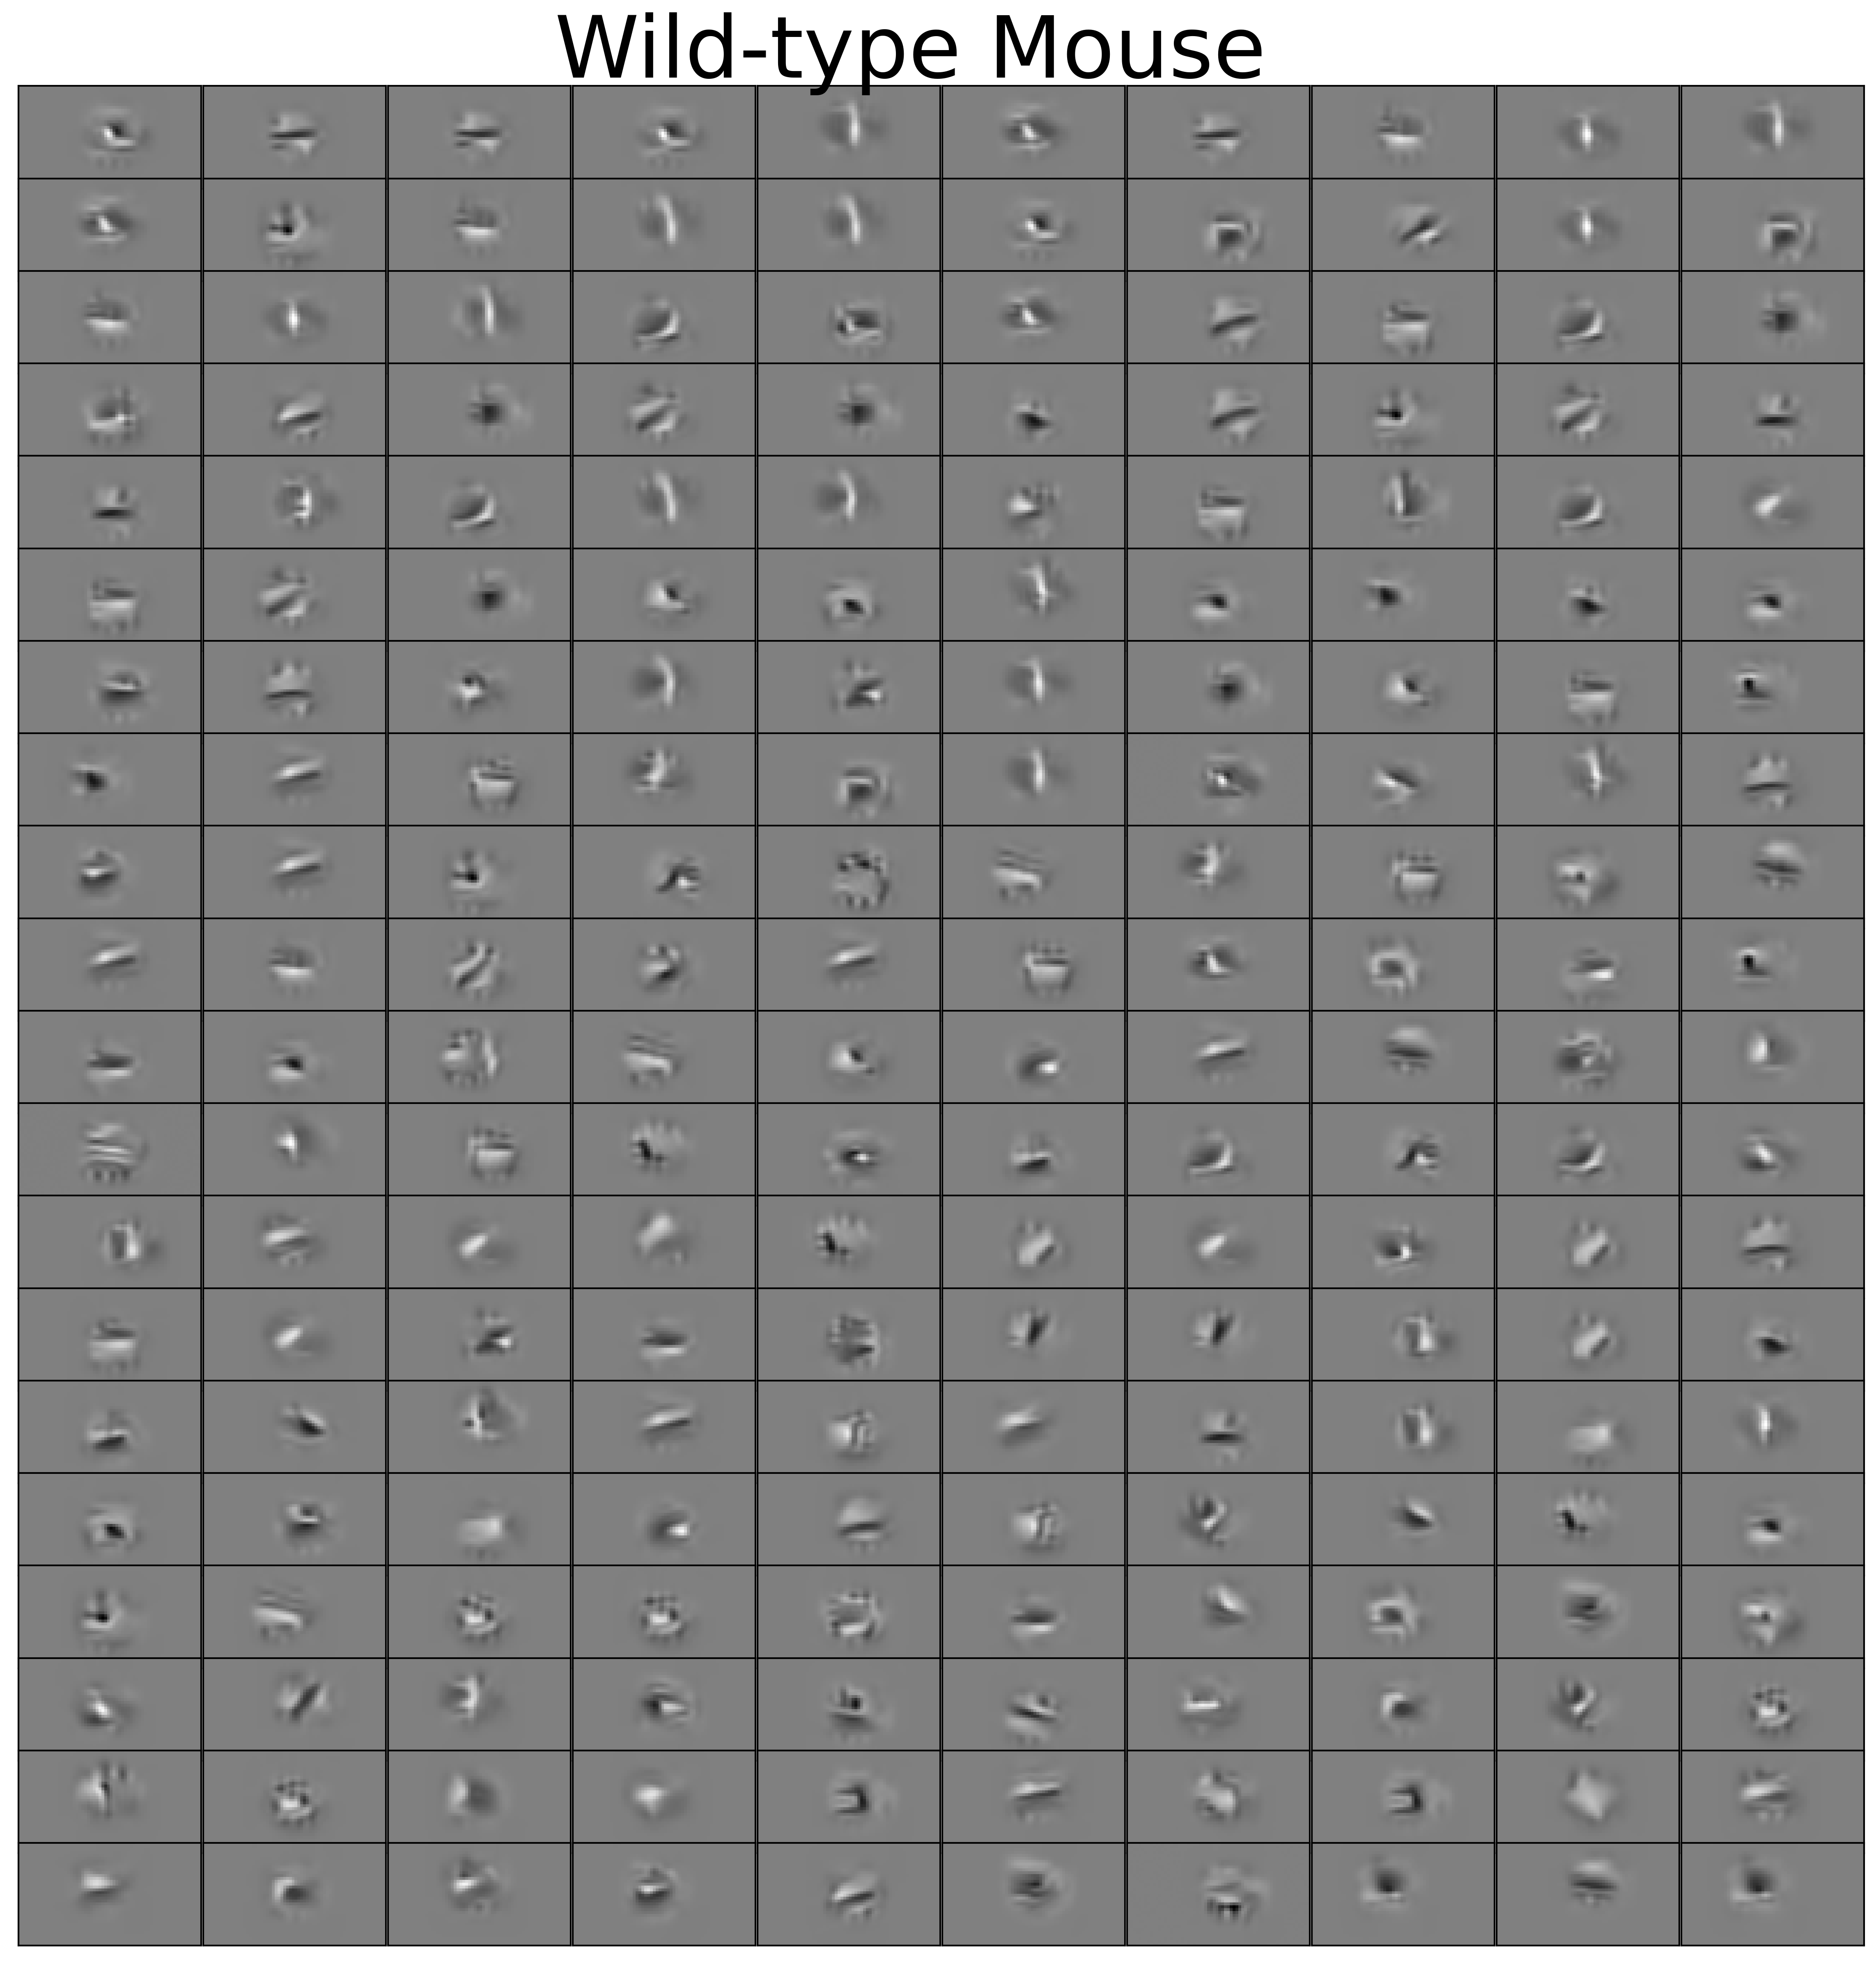

In [16]:
fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
plt.suptitle("Wild-type Mouse", y=0.91, fontsize=50)
for i in range(20):
    for j in range(10):
        index = i * 10 + j
        axes[i, j].imshow(meis_wt[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
plt.savefig("Plots/WildtypeMouseMEIsTop200.png", dpi=300)